In [89]:
import pandas as pd
import numpy as np
import random
import os 
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta
import numpy as np
from scipy.stats import norm
random.seed(1)
np.random.seed(1)

In [90]:
import pandas as pd
import numpy as np
import random
import os ### Kristen adding os file pathing too just for the sake of it


random.seed(1)
np.random.seed(1)
# ----------------------------
# Decay Functions (Factor Form)
# ----------------------------

def exponential_decay_factor(t, decay_rate):
    """
    Exponential decay factor that starts at 1 (no decay) and decreases over time.
    
    Args:
        t (int): Time index (e.g., day count).
        decay_rate (float): Decay rate.
    
    Returns:
        float: Decay factor.
    """
    return np.exp(-decay_rate * t)

def sigmoid_decay_factor(t, midpoint, steepness):
    """
    Sigmoid decay factor that transitions from near 1 to lower values over time.
    
    Args:
        t (int): Time index (e.g., day count).
        midpoint (float): The time at which the decay is halfway.
        steepness (float): Controls how steep the decay is.
    
    Returns:
        float: Decay factor.
    """
    # Shifted and scaled sigmoid so that at t=0 the factor is ~1.
    # Adjust the formula if necessary.
    return 1 / (1 + np.exp(steepness * (t - midpoint)))

# ----------------------------
# User Class Definition
# ----------------------------

class User:
    def __init__(self, user_id, group, base_params):
        """
        Initializes a user with a unique ID, group, and baseline parameters.
        
        Args:
            user_id (str): Unique identifier for the user.
            group (str): User group (e.g., 'Baseline', 'Drifters', 'Power Users').
            base_params (dict): Baseline parameters for each metric.
                For example:
                {
                  "engagement": {"mode": 50, "std": 7},
                  "ctr": {"low": 0.01, "high": 0.05}
                }
        """
        self.user_id = user_id
        self.group = group
        self.base_params = base_params  # These remain unchanged (Time A)
    
    def generate_data(self, start_date, end_date):
        """
        Generate daily data using the base (Time A) parameters.
        
        Args:
            start_date (str): Start date in 'YYYY-MM-DD'.
            end_date (str): End date in 'YYYY-MM-DD'.
        
        Returns:
            DataFrame: Simulated data for the user.
        """
        dates = pd.date_range(start=start_date, end=end_date)
        data = []
        for d in dates:
            # Simulate Engagement using a log-normal distribution
            engagement = np.random.lognormal(
                mean=np.log(self.base_params["engagement"]["mode"]),
                sigma=self.base_params["engagement"]["std"] / 100
            )
            # Simulate CTR using a uniform distribution
            ctr = np.random.uniform(
                self.base_params["ctr"]["low"],
                self.base_params["ctr"]["high"]
            )
            data.append({
                "Date": d,
                "UserID": self.user_id,
                "Group": self.group,
                "Engagement": engagement,
                "CTR": ctr
            })
        return pd.DataFrame(data)
    
    def generate_data_with_decay(self, start_date, end_date, decay_func, decay_params):
        """
        Generate daily data for Time B using a decay function that gradually changes the baseline.
        
        For each day, the engagement parameter is decayed according to its time index,
        so early days look like Time A and later days reflect the decay.
        
        Args:
            start_date (str): Start date in 'YYYY-MM-DD' for Time B.
            end_date (str): End date in 'YYYY-MM-DD' for Time B.
            decay_func (function): Decay factor function (e.g., exponential_decay_factor).
            decay_params (dict): Additional parameters for the decay function.
        
        Returns:
            DataFrame: Simulated Time B data.
        """
        dates = pd.date_range(start=start_date, end=end_date)
        data = []
        original_mode = self.base_params["engagement"]["mode"]
        
        for i, d in enumerate(dates):
            # Compute decay factor for this day; at t=0, factor should be close to 1.
            # decay_factor = decay_func(t=i, **decay_params)

            ### ADDED FOR JUST POWER USERS

            # if self.group == "Power Users":
            #     decay_factor = decay_func(t=i, **decay_params)
            # else:
            #     decay_factor = 1.0  # No decay for non-Power Users

            if self.base_params["engagement"]["mode"] >= 50:
                decay_factor = decay_func(t=i, **decay_params)
            else:
                decay_factor = 1.0  # No decay applied

            ### 
            # Decay the engagement mode over time
            decayed_mode = original_mode * decay_factor
            
            engagement = np.random.lognormal(
                mean=np.log(decayed_mode),
                sigma=self.base_params["engagement"]["std"] / 100
            )
            ctr = np.random.uniform(
                self.base_params["ctr"]["low"],
                self.base_params["ctr"]["high"]
            )
            data.append({
                "Date": d,
                "UserID": self.user_id,
                "Group": self.group,
                "Engagement": engagement,
                "CTR": ctr
            })
        return pd.DataFrame(data)
    
    def generate_data_with_growth(self, start_date, end_date, growth_func, growth_params):
        """
        Generate daily data for Time B using a growth function that gradually increases the baseline.
        
        For each day, the engagement parameter is increased according to its time index,
        so early days look like Time A and later days reflect the growth.
        
        Args:
            start_date (str): Start date in 'YYYY-MM-DD' for Time B.
            end_date (str): End date in 'YYYY-MM-DD' for Time B.
            growth_func (function): Growth factor function (e.g., exponential_growth_factor).
            growth_params (dict): Additional parameters for the growth function.
        
        Returns:
            DataFrame: Simulated Time B data reflecting growth.
        """
        dates = pd.date_range(start=start_date, end=end_date)
        data = []
        original_mode = self.base_params["engagement"]["mode"]
        
        for i, d in enumerate(dates):
            # Compute growth factor for this day; at t=0, factor should be 1.
            # If you want to apply growth only for high engagement users, adjust the condition.
            if self.base_params["engagement"]["mode"] >= 50:  # Adjust cutoff if needed.
                growth_factor = growth_func(t=i, **growth_params)
            else:
                growth_factor = 1.0  # No growth applied
            
            # Multiply original mode by growth factor
            grown_mode = original_mode * growth_factor
            
            engagement = np.random.lognormal(
                mean=np.log(grown_mode),
                sigma=self.base_params["engagement"]["std"] / 100
            )
            ctr = np.random.uniform(
                self.base_params["ctr"]["low"],
                self.base_params["ctr"]["high"]
            )
            data.append({
                "Date": d,
                "UserID": self.user_id,
                "Group": self.group,
                "Engagement": engagement,
                "CTR": ctr
            })
        return pd.DataFrame(data)

# ----------------------------
# Helper Functions for Data Generation
# ----------------------------

# def generate_users(n_users):
#     """
#     Generates a list of users with randomized baseline parameters.
    
#     Args:
#         n_users (int): Number of users.
    
#     Returns:
#         list: List of User objects.
#     """
#     users = []
#     for i in range(n_users):
#         user_id = f"U{i:04d}"
#         group = random.choice(["Baseline", "Drifters", "Power Users"])
#         base_params = {
#             "engagement": {"mode": random.uniform(30, 65), "std": random.uniform(5, 10)},
#             "ctr": {"low": random.uniform(0.01, 0.03), "high": random.uniform(0.03, 0.05)}
#         }
#         users.append(User(user_id, group, base_params))
#     return users




def generate_users(n_users):
    """
    Generates a list of users with randomized baseline parameters,
    using probability-based group assignments and double-layered randomness.
    
    Args:
        n_users (int): Number of users.
    
    Returns:
        list: List of User objects.
    """
    users = []
    # Define groups and their probabilities (e.g., Baseline 63%, Drifters 21%, Power Users 16%)
    groups = ["Baseline", "Drifters", "Power Users"]
    probabilities = [0.63, 0.21, 0.16]
    
    for i in range(n_users):
        user_id = f"U{i:07d}"
        # Choose a group based on defined probabilities
        group = random.choices(groups, weights=probabilities, k=1)[0]
        
        # Set base_params based on the user's group
        if group == "Baseline":
            # Double-layer randomness for engagement mode
            n1 = random.uniform(25, 40) # Mode Min
            n2 = random.uniform(55, 70) # Mode Max
            # For the standard deviation, add another layer
            n3 = random.uniform(3, 5) + random.gauss(0,.1)
            n4 = random.uniform(7, 10) + random.gauss(0,.1)
            base_params = {
                "engagement": {
                    "mode": random.uniform(n1, n2), 
                    "std": random.uniform(n3, n4)
                },
                "ctr": {
                    "low": random.uniform(0.01, 0.03), 
                    "high": random.uniform(0.03, 0.05)
                }
            }
        elif group == "Drifters":
            # Double-layer randomness for engagement mode
            n1 = random.uniform(15, 35) 
            n2 = random.uniform(45, 80)
            # For the standard deviation, add another layer
            n3 = random.uniform(4, 6) + random.gauss(0,.1)
            n4 = random.uniform(8, 12) + random.gauss(0,.1)
            base_params = {
                "engagement": {
                    "mode": random.uniform(n1, n2), 
                    "std": random.uniform(n3, n4)
                },
                "ctr": {
                    "low": random.uniform(0.01, 0.04), 
                    "high": random.uniform(0.07, 0.1)
                }
            }
        elif group == "Power Users":
            # Double-layer randomness for engagement mode
            n1 = random.uniform(60, 80)
            n2 = random.uniform(90, 110)
            # For the standard deviation, add another layer
            n3 = random.uniform(6, 8)
            n4 = random.uniform(10, 15)
            base_params = {
                "engagement": {
                    "mode": random.uniform(n1, n2), 
                    "std": random.uniform(n3, n4)
                },
                "ctr": {
                    "low": random.uniform(0.05, 0.1), 
                    "high": random.uniform(0.1, 0.2)
                }
            }
        
        # Create and append the user with the group-specific parameters
        users.append(User(user_id, group, base_params))
        
    return users


# def generate_time_series(users, start_date, end_date, use_decay=False, decay_func=None, decay_params=None):
#     """
#     Combines individual user data into one DataFrame.
    
#     Args:
#         users (list): List of User objects.
#         start_date (str): Start date for the data.
#         end_date (str): End date for the data.
#         use_decay (bool): If True, generate data with decay (Time B).
#         decay_func (function): Decay factor function to use.
#         decay_params (dict): Additional parameters for the decay function.
    
#     Returns:
#         DataFrame: Combined data.
#     """
#     df_list = []
#     for user in users:
#         if use_decay and decay_func is not None and decay_params is not None:
#             user_df = user.generate_data_with_decay(start_date, end_date, decay_func, decay_params)
#         else:
#             user_df = user.generate_data(start_date, end_date)
#         df_list.append(user_df)
#     return pd.concat(df_list, ignore_index=True)


def generate_time_series(users, start_date, end_date, drift_type=None, drift_func=None, drift_params=None):

    """
    Combines individual user data into one DataFrame, with an option to apply drift.
    
    Args:
        users (list): List of User objects.
        start_date (str): Start date for the data.
        end_date (str): End date for the data.
        drift_type (str or None): Type of drift to apply.
            - "decay": Use a decay function (simulate decreasing engagement)
            - "growth": Use a growth function (simulate increasing engagement)
            - None: No drift, i.e. normal data.
        drift_func (function): Drift factor function to use.
        drift_params (dict): Additional parameters for the drift function.
    
    Returns:
        DataFrame: Combined data.
    """
    df_list = []
    for user in users:
        if drift_type is not None and drift_func is not None and drift_params is not None:
            if drift_type.lower() == "decay":
                user_df = user.generate_data_with_decay(start_date, end_date, drift_func, drift_params)
            elif drift_type.lower() == "growth":
                user_df = user.generate_data_with_growth(start_date, end_date, drift_func, drift_params)
            else:
                # For unknown drift_type, fall back to normal data generation
                user_df = user.generate_data(start_date, end_date)
        else:
            user_df = user.generate_data(start_date, end_date)
        df_list.append(user_df)
    return pd.concat(df_list, ignore_index=True)


# ----------------------------
# Example Workflow: Generating Time A and Time B
# ----------------------------

# Generate Time A data (baseline)
start_date_a = "2024-01-01"
end_date_a = "2024-06-30"
users = generate_users(n_users=100)
time_a_df = generate_time_series(users, start_date_a, end_date_a)

# For Time B, we want to apply decay gradually.
# For example, using exponential decay with a decay_rate such that at t=0 the factor is 1.
# Modified decay
decay_rate = 0.005  # Adjust this value to control the decay speed.
decay_params = {"decay_rate": decay_rate}

# Generate Time B data with decay.
start_date_b = "2024-07-01"
end_date_b = "2024-12-31"
time_b_df_decay = generate_time_series(users, start_date_b, end_date_b, 
                                 drift_type="decay", drift_func=exponential_decay_factor, drift_params=decay_params)


### Kristen adding growth time B

def exponential_growth_factor(t, growth_rate):
    return 1 + (np.exp(growth_rate * t) - 1)
# Modified growth rate
growth_rate = 0.005
growth_params = {"growth_rate": growth_rate}

time_b_df_growth = generate_time_series(users, start_date_b, end_date_b, 
                                 drift_type="growth", drift_func=exponential_growth_factor, drift_params=growth_params)


### Kristen adding in normal time B too

time_b_df_normal = generate_time_series(users, start_date_b, end_date_b)


grouped_time_a = {group: time_a_df[time_a_df['Group'] == group] for group in ['Baseline', 'Drifters', 'Power Users']}
grouped_time_b = {group: time_b_df_decay[time_b_df_decay['Group'] == group] for group in ['Baseline', 'Drifters', 'Power Users']}


In [91]:
# time_a_df = pd.read_csv('Data/time_a.csv')
# time_b_df_decay = pd.read_csv('Data/time_b_df_decay.csv')
# time_b_df_growth =pd.read_csv('Data/time_b_df_growth.csv')
# time_b_df_normal = pd.read_csv('Data/time_b_df_normal.csv')

In [92]:
import numpy as np
from scipy.stats import norm

class DriftDetector:
    def __init__(self, baseline_data, window_size=7, threshold_drop=1):
        """
        Lightweight Bayesian drift detector using Gaussian likelihood scoring.

        Parameters:
        - baseline_data: np.array or pd.Series of engagement from Time A
        - window_size: number of days in each scoring window
        - threshold_drop: log-likelihood drop threshold to signal drift
        """
        self.window_size = window_size
        self.threshold_drop = threshold_drop
        self.mu = np.mean(baseline_data)
        self.sigma = np.std(baseline_data)
        self.fitted = True

    def compute_log_likelihood(self, window):
        return np.sum(norm.logpdf(window, loc=self.mu, scale=self.sigma))

    def detect(self, time_b_series):
        """
        Slides a window over Time B and returns the first changepoint (if any).
        """
        log_likelihoods = []
        changepoint = None

        for i in range(0, len(time_b_series) - self.window_size):
            window = time_b_series[i:i + self.window_size]
            ll = self.compute_log_likelihood(window)
            log_likelihoods.append(ll)

            if i >= 5:
                prev_avg = np.mean(log_likelihoods[max(0, i-5):i])
                if prev_avg - ll > self.threshold_drop:
                    changepoint = i + self.window_size
                    break

        return changepoint, log_likelihoods


In [93]:

def run_group_drift_detection(group_name, time_a_df, time_b_df, window_size=7, threshold_drop=1):
    group_a = time_a_df[time_a_df['Group'] == group_name]['Engagement'].values
    group_b = time_b_df[time_b_df['Group'] == group_name]['Engagement'].values

    detector = DriftDetector(baseline_data=group_a, window_size=window_size, threshold_drop=threshold_drop)
    changepoint, ll_trace = detector.detect(group_b)

    return changepoint, ll_trace

In [94]:
def evaluate_all_groups(time_a_df, time_b_df, time_b_start_date, window_size=7, threshold_drop=1):
    group_results = {}
    for group in ['Baseline', 'Drifters', 'Power Users']:
        cp_index, _ = run_group_drift_detection(group, time_a_df, time_b_df, window_size, threshold_drop)

        if cp_index is not None:
            cp_date = pd.to_datetime(time_b_start_date) + pd.Timedelta(days=cp_index)
        else:
            cp_date = "Not Detected"

        group_results[group] = {
            "changepoint_index": cp_index,
            "changepoint_date": cp_date
        }

    return group_results

In [95]:
def plot_log_likelihoods(ll_trace, title="Log-Likelihood Drift Detection"):
    plt.plot(ll_trace)
    plt.title(title)
    plt.xlabel("Window Index")
    plt.ylabel("Log-Likelihood")
    plt.axvline(np.argmax(np.diff(ll_trace)), color='red', linestyle='--')
    plt.grid(True)
    plt.show()

In [96]:
# group = "Power Users"  # or "Baseline", or "Drifters"

# # Extract engagement values for the selected group from Time A and Time B
# group_a = time_a_df[time_a_df['Group'] == group]['Engagement'].values
# group_b = time_b_df_decay[time_b_df_decay['Group'] == group]['Engagement'].values

# print(f"🔍 Analyzing group: {group}")
# print(f"Time A size: {len(group_a)}, Time B size: {len(group_b)}")

In [97]:
# detector = DriftDetector(baseline_data=group_a, window_size=7, threshold_drop=1)
# changepoint, ll_trace = detector.detect(group_b)

# print(f"Changepoint: {changepoint}")


In [98]:
# import matplotlib.pyplot as plt

# plt.plot(ll_trace)
# plt.axhline(np.mean(ll_trace[:5]), color='red', linestyle='--', label="Early Avg")
# plt.title(f"Log-Likelihood Drift Trace for {group}")
# plt.xlabel("Window Index")
# plt.ylabel("Log-Likelihood")
# plt.grid(True)
# plt.legend()
# plt.show()


In [99]:
# results = evaluate_all_groups(time_a_df, time_b_df_decay, "2024-07-01")
# for group, info in results.items():
#     print(f"{group} ➜ Detected changepoint: {info['changepoint_date']}")

In [100]:

def plot_group_drift_detection(time_b_df, results, time_b_start_date):
    time_b_df = time_b_df.copy()
    time_b_df['Date'] = pd.to_datetime(time_b_df['Date'])

    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    for i, group in enumerate(['Baseline', 'Drifters', 'Power Users']):
        group_df = time_b_df[time_b_df['Group'] == group]
        group_df['Month'] = group_df['Date'].dt.to_period('M').astype(str)

        ax = axs[i]
        sns.boxplot(data=group_df, x='Month', y='Engagement', ax=ax)
        ax.set_title(f"Group = {group}")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

        # Mark true changepoint
        true_cp_date = pd.to_datetime(time_b_start_date)
        ax.axvline(x=0, color='green', linestyle='--', label='True Drift Start')

        # Mark detected changepoint
        cp_index = results[group]["changepoint_index"]
        if cp_index is not None:
            detected_cp_date = pd.to_datetime(time_b_start_date) + pd.Timedelta(days=cp_index)
            ax.axvline(
                x=(detected_cp_date.to_period('M') - true_cp_date.to_period('M')).n, 
                color='red', linestyle='-', label='Detected Drift'
            )

        if i == 0:
            ax.set_ylabel("Engagement")
        else:
            ax.set_ylabel("")

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2)
    fig.suptitle("📈 Monthly Engagement + Drift Detection Lines", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [101]:
def plot_group_drift_detection_lineplot(time_b_df, results, time_b_start_date):
    time_b_df = time_b_df.copy()
    time_b_df['Date'] = pd.to_datetime(time_b_df['Date'])

    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    for i, group in enumerate(['Baseline', 'Drifters', 'Power Users']):
        group_df = time_b_df[time_b_df['Group'] == group].copy()
        daily_engagement = group_df.groupby('Date')['Engagement'].mean()

        ax = axs[i]
        ax.plot(daily_engagement.index, daily_engagement.values, label="Engagement", color='blue')
        ax.set_title(f"Group: {group}")
        ax.set_xlabel("Date")
        if i == 0:
            ax.set_ylabel("Engagement")

        true_cp_date = pd.to_datetime(time_b_start_date)
        ax.axvline(x=true_cp_date, color='green', linestyle='--', label='True Drift Start')

        cp_index = results[group]["changepoint_index"]
        if cp_index is not None:
            detected_cp_date = true_cp_date + pd.Timedelta(days=cp_index)
            # Cap the detected date by the maximum date in the group data
            max_date = group_df['Date'].max()
            if detected_cp_date > max_date:
                detected_cp_date = max_date
            ax.axvline(x=detected_cp_date, color='red', linestyle='-', label='Detected Drift')

        ax.grid(True)
        ax.legend()

    fig.suptitle("📉 Daily Engagement with Drift Detection per Group", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


C:\Users\JPMorgan\AppData\Local\Temp\ipykernel_15048\1870748553.py:34: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\JPMorgan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


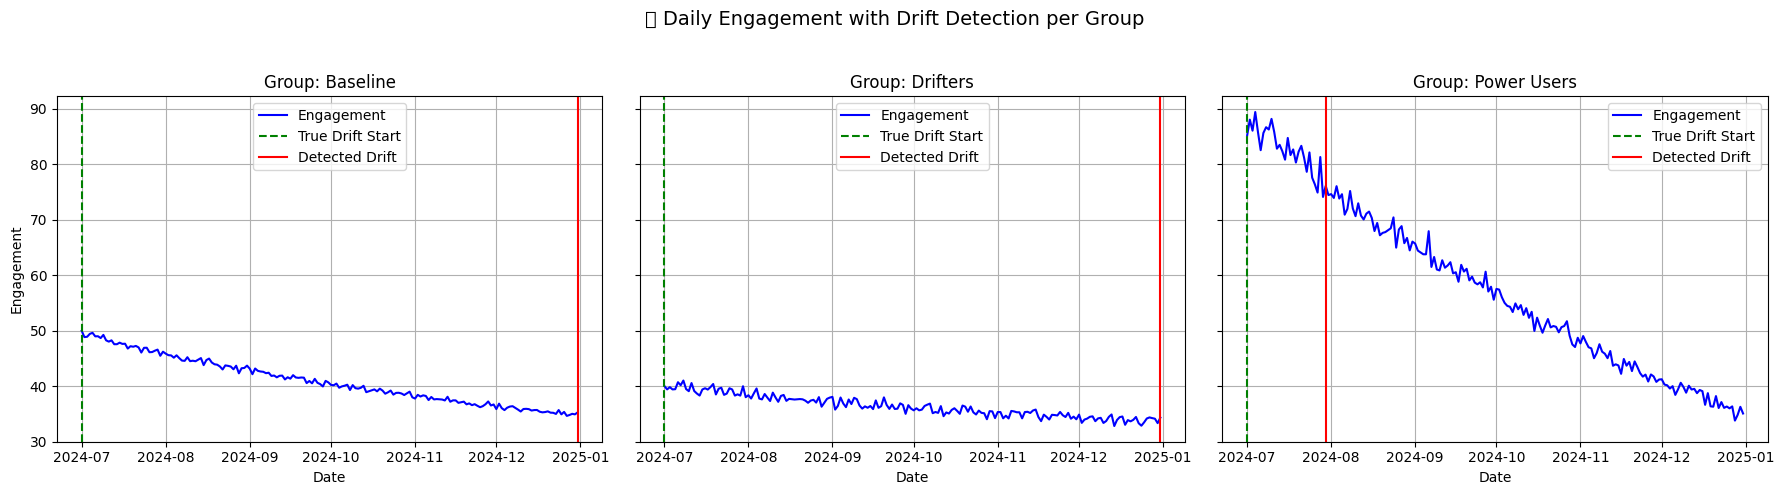

C:\Users\JPMorgan\AppData\Local\Temp\ipykernel_15048\1870748553.py:34: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\JPMorgan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


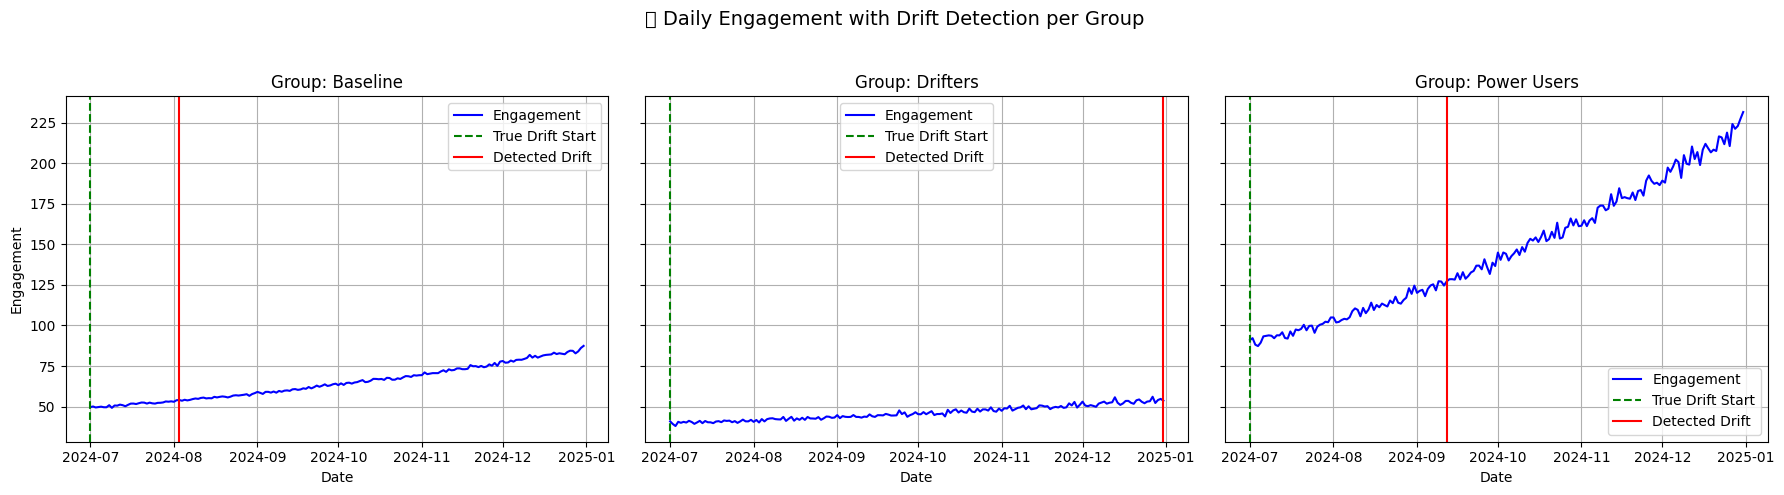

C:\Users\JPMorgan\AppData\Local\Temp\ipykernel_15048\1870748553.py:34: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\JPMorgan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


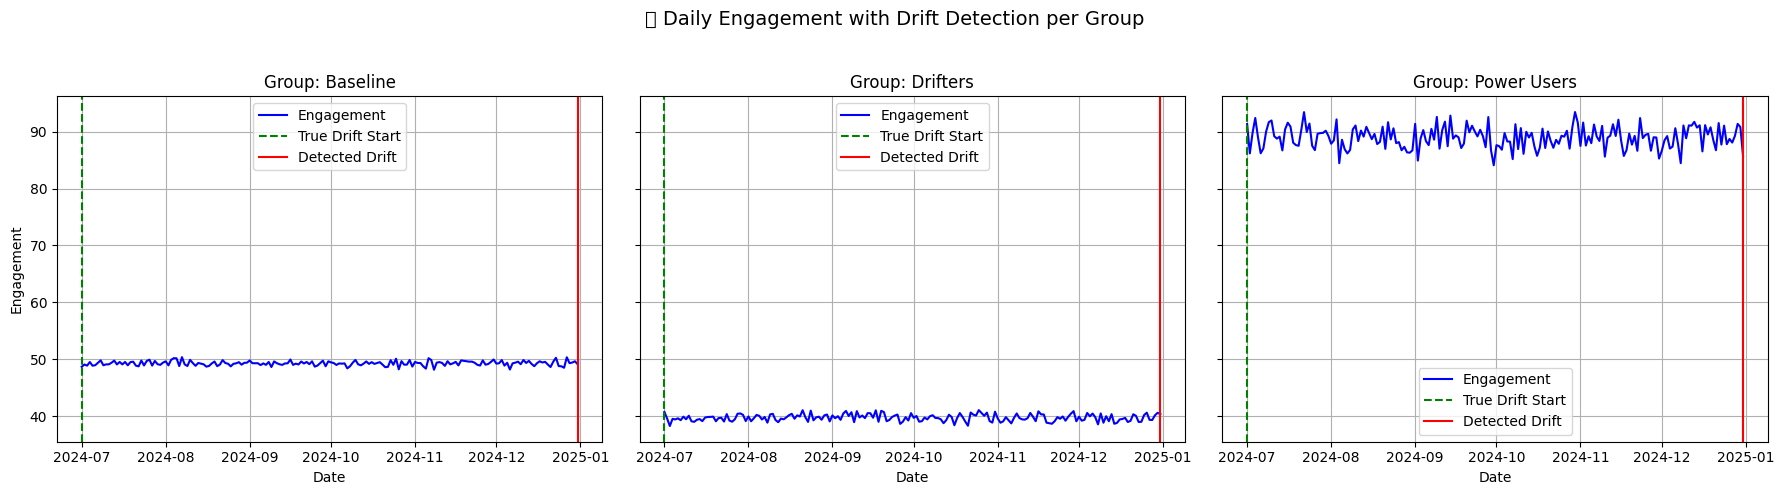

In [102]:
results_decay = evaluate_all_groups(time_a_df, time_b_df_decay, "2024-07-01", window_size=21, threshold_drop=4)
results_growth = evaluate_all_groups(time_a_df, time_b_df_growth, "2024-07-01", window_size=21, threshold_drop=4)
results_normal = evaluate_all_groups(time_a_df, time_b_df_normal, "2024-07-01", window_size=21, threshold_drop=4)

# Plot line plots for each:
plot_group_drift_detection_lineplot(time_b_df_decay, results_decay, "2024-07-01")
plot_group_drift_detection_lineplot(time_b_df_growth, results_growth, "2024-07-01")
plot_group_drift_detection_lineplot(time_b_df_normal, results_normal, "2024-07-01")



In [107]:
def evaluate_drift_error(time_a_df, time_b_df, time_b_start_date, 
                         drift_rate,  # the simulated drift rate used in the data generation
                         window_size=7, 
                         threshold_drop=1, 
                         lambda_weight=1.0, 
                         false_detection_penalty=100):
    """
    Evaluates drift detection performance for each group using a composite error metric.
    
    For each group:
      - t_d: the detected changepoint (in days from Time B start)
      - Compute μ_start as the average engagement in the first window of Time B.
      - Compute μ_detect as the average engagement in the window ending at t_d.
      - actual_drop = 100 * (1 - (μ_detect / μ_start)) for decay
      - expected_drop = 100 * (1 - exp(-drift_rate * t_d))
      - Composite error = t_d + lambda_weight * |actual_drop - expected_drop|
      - If drift is not detected (t_d is None), assign error = false_detection_penalty.
    
    Returns:
      - total_error: sum of composite errors across groups.
      - group_errors: dictionary mapping groups to their error and detected cp.
    """
    total_error = 0
    group_errors = {}
    true_start = pd.to_datetime(time_b_start_date)
    
    for group in ["Baseline", "Drifters", "Power Users"]:
        # Get baseline engagement for this group from Time A.
        group_a = time_a_df[time_a_df['Group'] == group]['Engagement'].values
        mu_A = np.mean(group_a)
        
        # Run the drift detector.
        cp_index, _ = run_group_drift_detection(group, time_a_df, time_b_df, 
                                                  window_size=window_size, threshold_drop=threshold_drop)
        # Get Time B subset for this group.
        group_b_df = time_b_df[time_b_df['Group'] == group].copy()
        group_b_df['Date'] = pd.to_datetime(group_b_df['Date'])
        
        # Assume μ_start is computed from the first window (first 'window_size' days) of Time B.
        group_b_sorted = group_b_df.sort_values("Date")
        initial_window = group_b_sorted.head(window_size)
        if not initial_window.empty:
            mu_start = initial_window["Engagement"].mean()
        else:
            mu_start = mu_A  # fallback
        
        if cp_index is None:
            error = false_detection_penalty
            detected_cp = None
        else:
            detected_cp = cp_index  # in days after Time B start
            # Find the detection window: all data before the detected changepoint.
            detected_data = group_b_sorted[group_b_sorted["Date"] < true_start + pd.Timedelta(days=cp_index)]
            if detected_data.empty:
                mu_detect = mu_start
            else:
                mu_detect = detected_data["Engagement"].mean()
            # For decay:
            actual_drop = 100 * (1 - (mu_detect / mu_start))
            expected_drop = 100 * (1 - np.exp(-drift_rate * cp_index))
            
            error = cp_index + lambda_weight * abs(actual_drop - expected_drop)
        
        group_errors[group] = {"error": error, "detected_cp": detected_cp, 
                                 "mu_start": mu_start,
                                 "mu_detect": mu_detect if cp_index is not None else None,
                                 "actual_drop": actual_drop if cp_index is not None else None,
                                 "expected_drop": expected_drop if cp_index is not None else None}
        total_error += error
        
    return total_error, group_errors


In [108]:
# Define parameter grids.
drift_rates = list(np.arange(0.001, 0.01, 0.001)) # possible decay rates to test
window_sizes = list(range(5, 14, 1))                        # possible window sizes (days)
threshold_drops = list(np.arange(0.1, 2.5, 0.2))   

# Expected behavior: For decay, let's assume we want the drift to be caught quickly (around 15 days).
# Our evaluation function now uses the simulation's drift rate to compute expected drop.
lambda_weight = 1.0  # weight for magnitude error
false_detection_penalty = 100

results_grid = []
best_error = np.inf
best_params = None
start_date_b = "2024-07-01"

for dr in drift_rates:
    # Set drift parameters for decay.
    decay_params = {"decay_rate": dr}
    
    # Generate new Time B dataset with decay.
    time_b_df_drift = generate_time_series(users, start_date_b, "2024-12-31", 
                                drift_type="decay", drift_func=exponential_decay_factor, 
                                drift_params=decay_params)
    
    # We'll use this time_b_df_drift for evaluation.
    for ws in window_sizes:
        for td in threshold_drops:
            total_error, group_errors = evaluate_drift_error(time_a_df, time_b_df_drift, start_date_b,
                                                              drift_rate=dr, window_size=ws, threshold_drop=td,
                                                              lambda_weight=lambda_weight,
                                                              false_detection_penalty=false_detection_penalty)
            results_grid.append((dr, ws, td, total_error, group_errors))
            if total_error < best_error:
                best_error = total_error
                best_params = (dr, ws, td, total_error, group_errors)

grid_df = pd.DataFrame(results_grid, columns=["drift_rate", "window_size", "threshold_drop", "total_error", "group_errors"])
print("Grid Search Results:")
print(grid_df.sort_values("total_error").reset_index(drop=True))
print("\nBest parameters (drift_rate, window_size, threshold_drop, total_error, group_errors):", best_params)


Grid Search Results:
     drift_rate  window_size  threshold_drop  total_error  \
0         0.004            6             0.1    50.631867   
1         0.004            5             0.1    52.993543   
2         0.002            5             0.1    60.388401   
3         0.001            7             0.1    60.475925   
4         0.002            6             0.1    64.000955   
..          ...          ...             ...          ...   
967       0.003            6             2.3  2008.514005   
968       0.004           11             2.3  2013.782715   
969       0.003           13             2.3  2015.322523   
970       0.008            5             2.1  2271.816887   
971       0.008            5             2.3  2271.816887   

                                          group_errors  
0    {'Baseline': {'error': 11.36652756955885, 'det...  
1    {'Baseline': {'error': 15.42487227480104, 'det...  
2    {'Baseline': {'error': 13.46827026320302, 'det...  
3    {'Baseline': 

In [109]:
grid_df

,drift_rate,window_size,threshold_drop,total_error,group_errors
0,0.001,5,0.1,70.651959,"{'Baseline': {'error': 23.623331959113457, 'de..."
1,0.001,5,0.3,243.115523,"{'Baseline': {'error': 23.623331959113457, 'de..."
2,0.001,5,0.5,243.115523,"{'Baseline': {'error': 23.623331959113457, 'de..."
3,0.001,5,0.7,253.209705,"{'Baseline': {'error': 24.515344495215242, 'de..."
4,0.001,5,0.9,253.209705,"{'Baseline': {'error': 24.515344495215242, 'de..."
...,...,...,...,...,...
967,0.009,13,1.5,356.201351,"{'Baseline': {'error': 67.71009841196285, 'det..."
968,0.009,13,1.7,367.482957,"{'Baseline': {'error': 78.99170390771886, 'det..."
969,0.009,13,1.9,368.864194,"{'Baseline': {'error': 80.37294052834994, 'det..."
970,0.009,13,2.1,376.917083,"{'Baseline': {'error': 87.25632256300219, 'det..."


In [104]:
# # Define parameter grids.
# drift_rates = list(np.arange(0.001, 0.01, 0.001)) # possible decay rates to test
# window_sizes = list(range(5, 14, 1))                        # possible window sizes (days)
# threshold_drops = list(np.arange(0.1, 2.5, 0.2))                    # possible threshold drop values

# # Define expected changepoint values per group.
# expected_cp_dict = {
#     "Baseline": None,    # No drift expected for normal baseline behavior.
#     "Drifters": None,    # No drift expected for drifters.
#     "Power Users": 14    # Expect drift to be detected around day 15 for Power Users.
# }

# results_grid = []
# best_error = np.inf
# best_params = None
# start_date_b = "2024-07-01"

# # Grid search loop.
# for dr in drift_rates:
#     # Update drift parameters (for decay).
#     decay_params = {"decay_rate": dr}
    
#     # For each drift_rate, generate a new Time B dataset with decay drift applied.
#     time_b_df_drift = generate_time_series(users, start_date_b, "2024-12-31", 
#                                             drift_type="decay", drift_func=exponential_decay_factor, 
#                                             drift_params=decay_params)
    
#     for ws in window_sizes:
#         for td in threshold_drops:
#             total_error, group_errors = evaluate_hyperparameters_custom(
#                 time_a_df, time_b_df_drift, start_date_b, expected_cp_dict,
#                 window_size=ws, threshold_drop=td,
#                 penalty_normal=50, penalty_missing=100)
            
#             results_grid.append((dr, ws, td, total_error, group_errors))
#             if total_error < best_error:
#                 best_error = total_error
#                 best_params = (dr, ws, td, total_error, group_errors)

# # Convert grid search results to DataFrame for easy viewing.
# grid_df = pd.DataFrame(results_grid, columns=["drift_rate", "window_size", "threshold_drop", "total_error", "group_errors"])
# print("Grid Search Results:")
# print(grid_df.sort_values("total_error").reset_index(drop=True))

# print("\nBest parameters (drift_rate, window_size, threshold_drop, total_error, group_errors):", best_params)


Grid Search Results:
     drift_rate  window_size  threshold_drop  total_error  \
0         0.003            6             0.1          126   
1         0.003            5             0.1          127   
2         0.003            7             0.1          128   
3         0.003            8             0.1          128   
4         0.003            9             0.1          131   
..          ...          ...             ...          ...   
967       0.002           12             2.1         1966   
968       0.002           13             2.1         1966   
969       0.002           13             2.3         1967   
970       0.002           12             2.3         1974   
971       0.002            9             2.3         1997   

                                          group_errors  
0    {'Baseline': 63, 'Drifters': 61, 'Power Users'...  
1    {'Baseline': 63, 'Drifters': 60, 'Power Users'...  
2    {'Baseline': 64, 'Drifters': 62, 'Power Users'...  
3    {'Baseline': 